# Single model

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import SimulatedMinimumDistance as SMD
import figs
import funs

# Global modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Solve and simulate model

In [26]:
SingleEst = SMD.load_est(name='Single')
Single = RetirementClass(**SingleEst)
Single.solve()
Single.simulate()

### Retirement probabilities from solution

Women

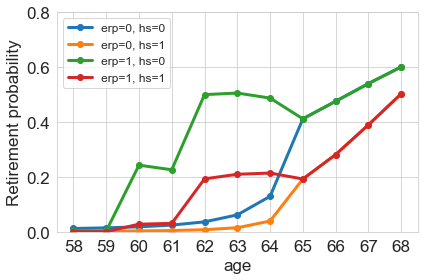

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.choice_probs(Single,ax,ma=0,ylim=[0,0.8])
fig.tight_layout()
fig.savefig('figs/Model/Single_ChoiceProb_Women.png')

Men

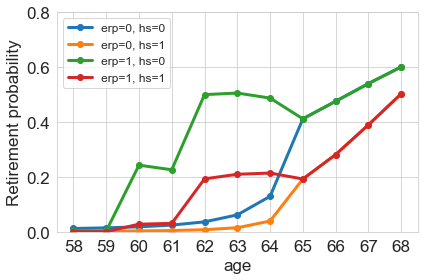

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.choice_probs(Single,ax,ma=0,ylim=[0,0.8])
fig.tight_layout()
fig.savefig('figs/Model/Single_ChoiceProb_Women.png')

### Consumption functions

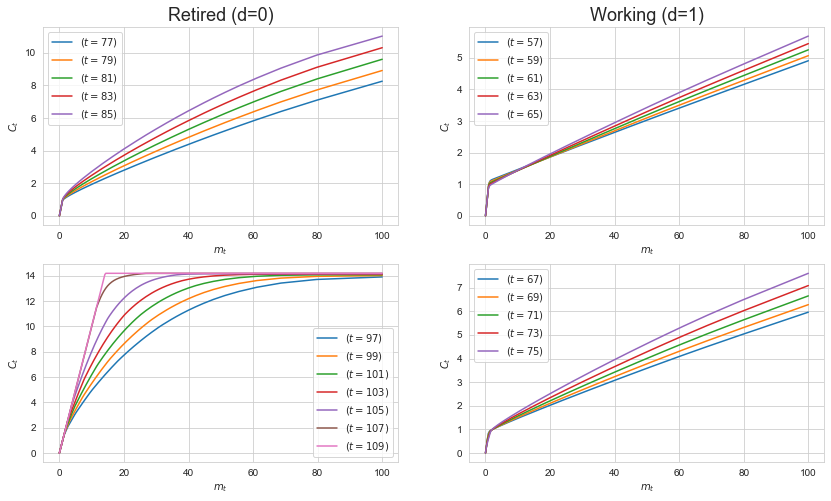

In [29]:
fig, axs = plt.subplots(2,2,figsize=(14,8))
time = list(range(20,30))
figs.policy(Single,axs[0,0],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[0],label=['t'])
time = list(range(40,53))
figs.policy(Single,axs[1,0],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[0],label=['t'])
time = list(range(10))
figs.policy(Single,axs[0,1],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[1],label=['t'])
time = list(range(10,20))
figs.policy(Single,axs[1,1],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[1],label=['t'])
axs[0,0].set_title('Retired (d=0)',size=18)
axs[0,1].set_title('Working (d=1)',size=18)
plt.show()

### Simulation

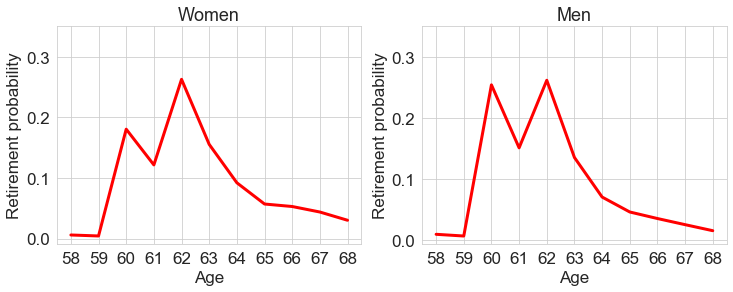

In [31]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.retirement_probs(Single,axs[0],MA=[0])
figs.retirement_probs(Single,axs[1],MA=[1])
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
plt.show()

In [20]:
Single = RetirementClass()

In [21]:
Single.solve()

In [22]:
Single.simulate()

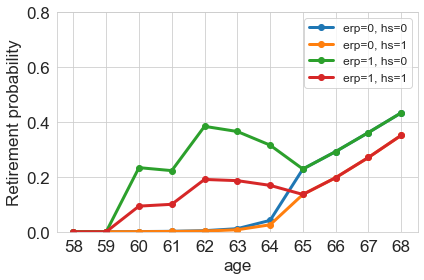

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.choice_probs(Single,ax,ma=0,ylim=[0,0.8])
fig.tight_layout()
fig.savefig('figs/Model/Single_ChoiceProb_Women.png')

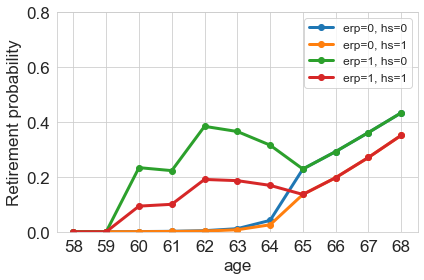

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.choice_probs(Single,ax,ma=0,ylim=[0,0.8])
fig.tight_layout()
fig.savefig('figs/Model/Single_ChoiceProb_Women.png')

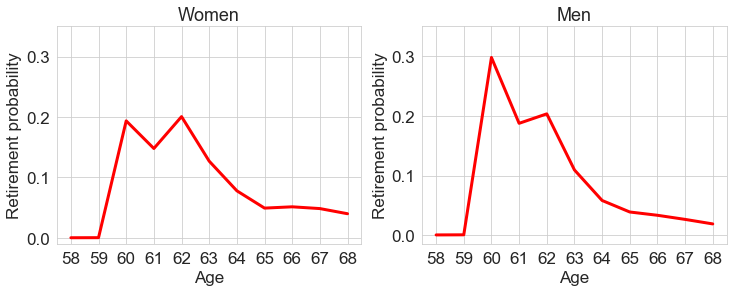

In [25]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.retirement_probs(Single,axs[0],MA=[0])
figs.retirement_probs(Single,axs[1],MA=[1])
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
plt.show()

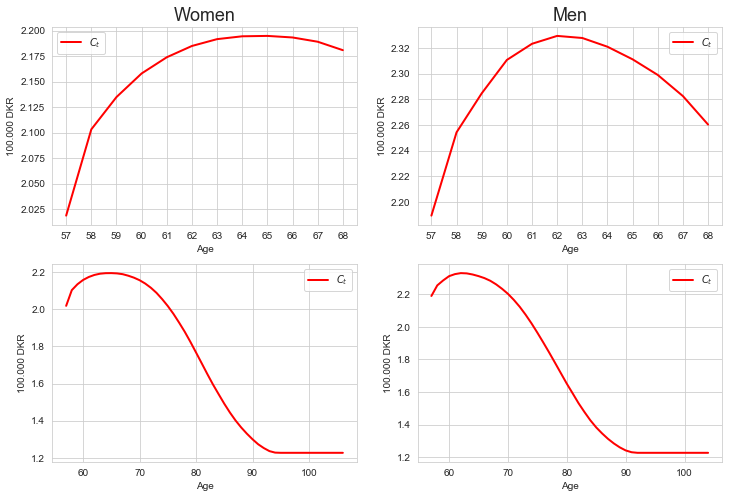

In [26]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.lifecycle(Single,axs[0,0],MA=[0],vars=['c'])
figs.lifecycle(Single,axs[0,1],MA=[1],vars=['c'])
figs.lifecycle(Single,axs[1,0],MA=[0],vars=['c'],ages=[57,110])
figs.lifecycle(Single,axs[1,1],MA=[1],vars=['c'],ages=[57,110])
axs[0,0].set_title('Women',size=18)
axs[0,1].set_title('Men',size=18)
plt.show()

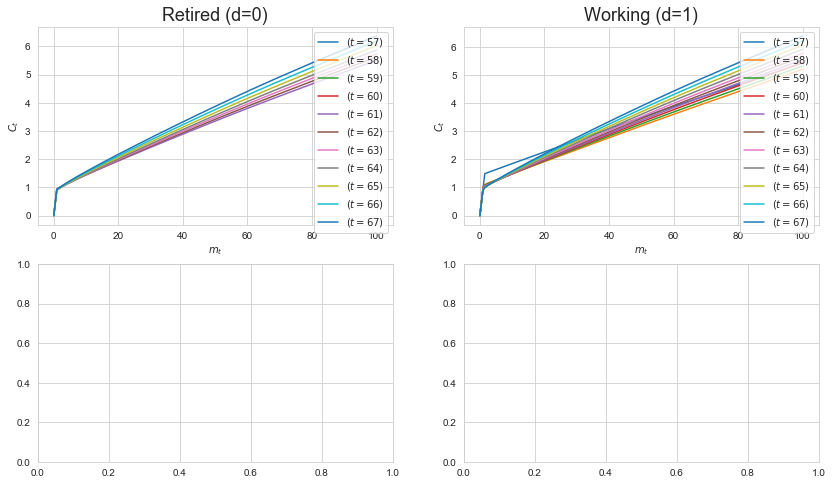

In [44]:
fig, axs = plt.subplots(2,2,figsize=(14,8))
figs.policy(Single,axs[0,1],var='c',T=[0,1,2,3,4,5,6,7,8,9,10],MA=[0],ST=[3],RA=[0],D=[1],label=['t'])
figs.policy(Single,axs[0,0],var='c',T=[0,1,2,3,4,5,6,7,8,9,10],MA=[0],ST=[3],RA=[0],D=[0],label=['t'])
axs[0,0].set_title('Retired (d=0)',size=18)
axs[0,1].set_title('Working (d=1)',size=18)
plt.show()

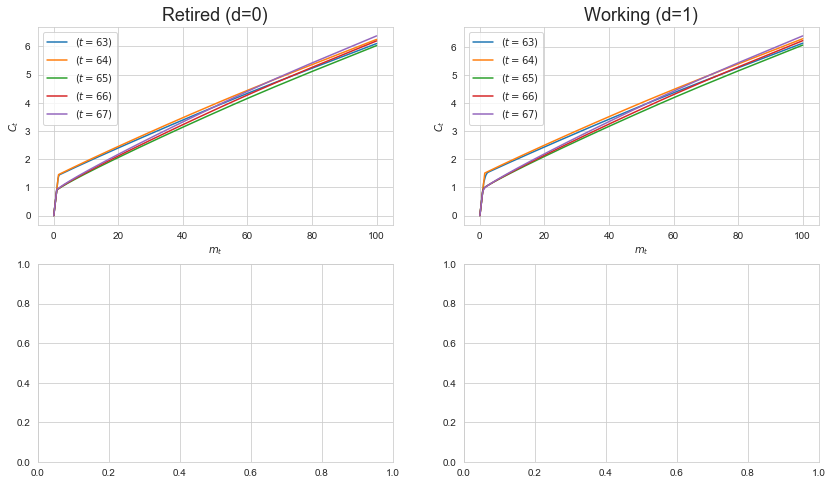

In [29]:
fig, axs = plt.subplots(2,2,figsize=(14,8))
#time = list(range(20,30))
#figs.policy(Single,axs[0,0],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[0],label=['t'])
#time = list(range(40,53))
#figs.policy(Single,axs[1,0],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[0],label=['t'])
figs.policy(Single,axs[0,1],var='c',T=[6,7,8,9,10],MA=[0],ST=[3],RA=[0],D=[1],label=['t'])
figs.policy(Single,axs[0,0],var='c',T=[6,7,8,9,10],MA=[0],ST=[3],RA=[0],D=[0],label=['t'])
#time = list(range(10,20))
#figs.policy(Single,axs[1,1],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[1],label=['t'])
axs[0,0].set_title('Retired (d=0)',size=18)
axs[0,1].set_title('Working (d=1)',size=18)
plt.show()

In [286]:
import time
for i in range(10):
    tic = time.time()
    Single.simulate()
    print(time.time()-tic)

1.2692596912384033
1.1633381843566895
1.1973145008087158
1.175325632095337
1.1533424854278564
1.29925537109375
1.3292384147644043
1.524127721786499
1.2093067169189453
1.42918062210083


In [285]:
Single.par.simT = 54
Single.recompute()

### Plot for women and men

In [248]:
Single = RetirementClass(simT=12)
Single.solve()

In [292]:
Single.simulate(accuracy=True)

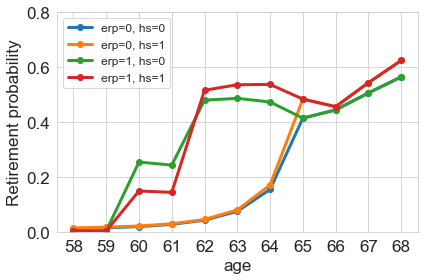

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.choice_probs(Single,ax,ma=0,ylim=[0,0.8])
fig.tight_layout()
fig.savefig('figs/Model/Single_ChoiceProb_Women.png')

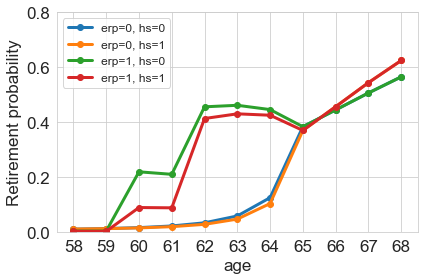

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.choice_probs(Single,ax,ma=0,ylim=[0,0.8])
fig.tight_layout()
fig.savefig('figs/Model/Single_ChoiceProb_Women.png')

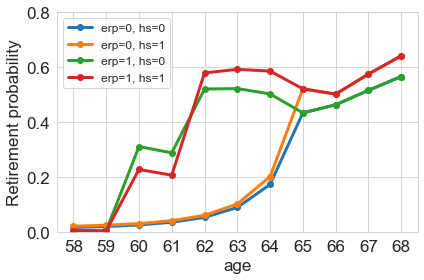

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.choice_probs(Single,ax,ma=1,ylim=[0,0.8])
fig.tight_layout()
fig.savefig('figs/Model/Single_ChoiceProb_Women.png')

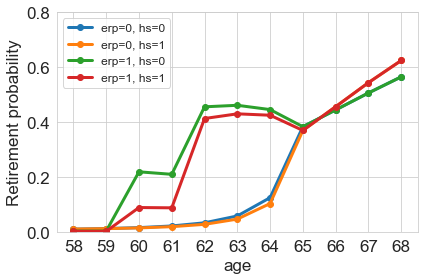

In [287]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.choice_probs(Single,ax,ma=0,ylim=[0,0.8])
fig.tight_layout()
fig.savefig('figs/Model/Single_ChoiceProb_Women.png')

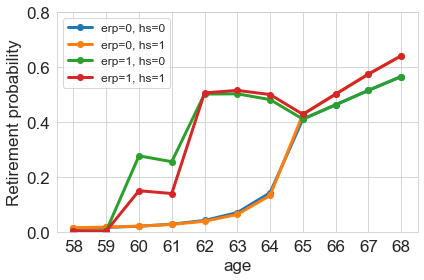

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.choice_probs(Single,ax,ma=1,ylim=[0,0.8])
fig.tight_layout()
fig.savefig('figs/Model/Single_ChoiceProb_Men.png')

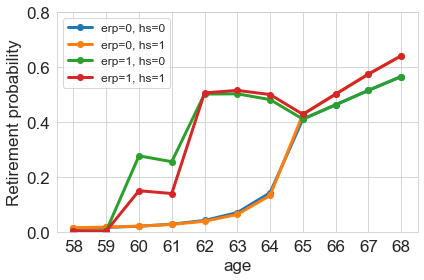

In [288]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.choice_probs(Single,ax,ma=1,ylim=[0,0.8])
fig.tight_layout()
fig.savefig('figs/Model/Single_ChoiceProb_Men.png')

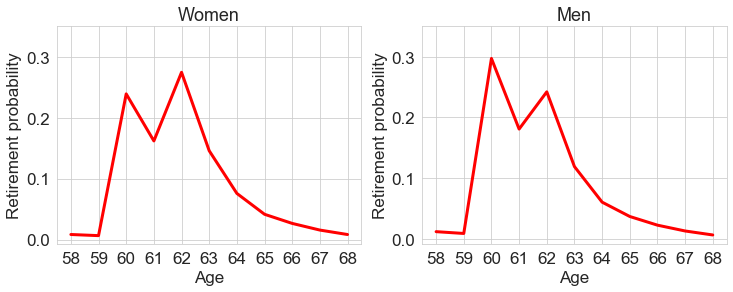

In [39]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.retirement_probs(Single,axs[0],MA=[0])
figs.retirement_probs(Single,axs[1],MA=[1])
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
plt.show()

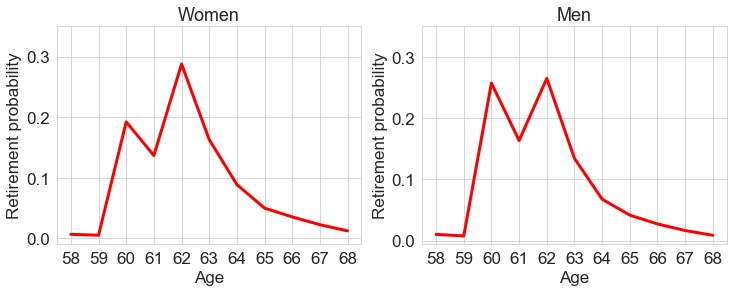

In [7]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.retirement_probs(Single,axs[0],MA=[0])
figs.retirement_probs(Single,axs[1],MA=[1])
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
plt.show()

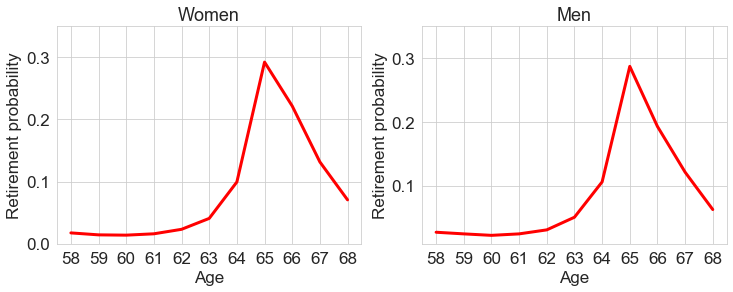

In [290]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.retirement_probs(Single,axs[0],MA=[0],ST=[0])
figs.retirement_probs(Single,axs[1],MA=[1],ST=[0])
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
plt.show()

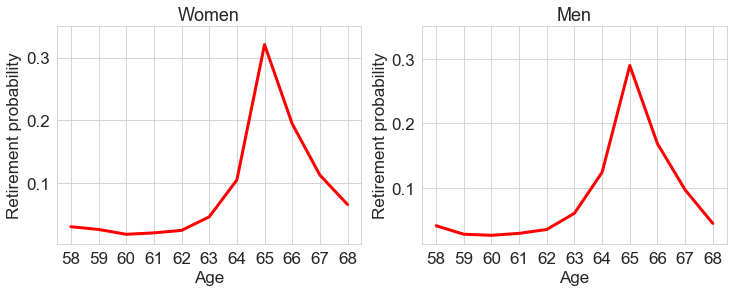

In [291]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.retirement_probs(Single,axs[0],MA=[0],ST=[1])
figs.retirement_probs(Single,axs[1],MA=[1],ST=[1])
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
plt.show()

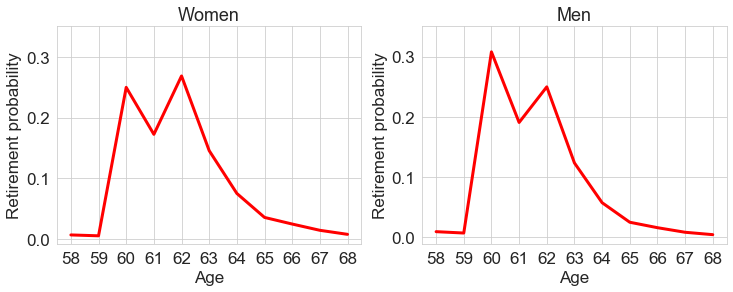

In [10]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.retirement_probs(Single,axs[0],MA=[0],ST=[2])
figs.retirement_probs(Single,axs[1],MA=[1],ST=[2])
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
plt.show()

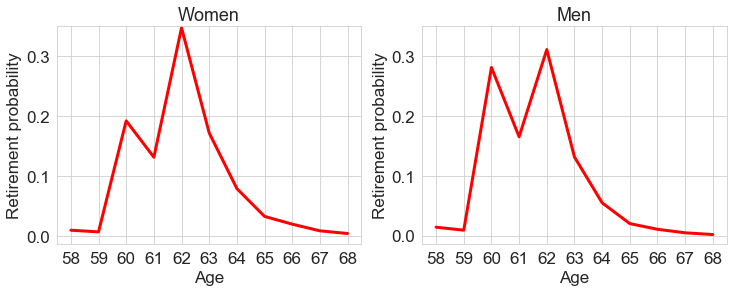

In [11]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.retirement_probs(Single,axs[0],MA=[0],ST=[3])
figs.retirement_probs(Single,axs[1],MA=[1],ST=[3])
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
plt.show()

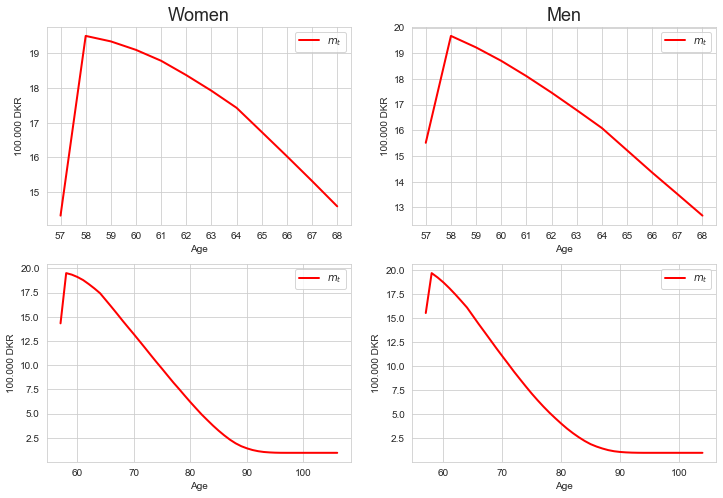

In [46]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.lifecycle(Single,axs[0,0],MA=[0],vars=['m'])
figs.lifecycle(Single,axs[0,1],MA=[1],vars=['m'])
figs.lifecycle(Single,axs[1,0],MA=[0],vars=['m'],ages=[57,110])
figs.lifecycle(Single,axs[1,1],MA=[1],vars=['m'],ages=[57,110])
axs[0,0].set_title('Women',size=18)
axs[0,1].set_title('Men',size=18)
plt.show()

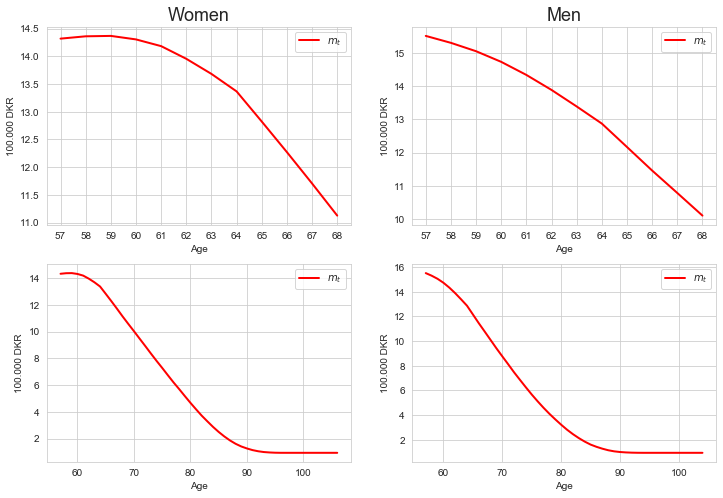

In [293]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.lifecycle(Single,axs[0,0],MA=[0],vars=['m'])
figs.lifecycle(Single,axs[0,1],MA=[1],vars=['m'])
figs.lifecycle(Single,axs[1,0],MA=[0],vars=['m'],ages=[57,110])
figs.lifecycle(Single,axs[1,1],MA=[1],vars=['m'],ages=[57,110])
axs[0,0].set_title('Women',size=18)
axs[0,1].set_title('Men',size=18)
plt.show()

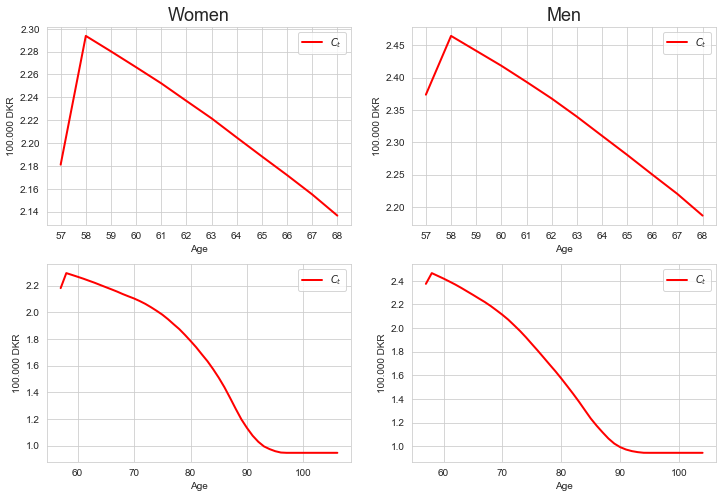

In [47]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.lifecycle(Single,axs[0,0],MA=[0],vars=['c'])
figs.lifecycle(Single,axs[0,1],MA=[1],vars=['c'])
figs.lifecycle(Single,axs[1,0],MA=[0],vars=['c'],ages=[57,110])
figs.lifecycle(Single,axs[1,1],MA=[1],vars=['c'],ages=[57,110])
axs[0,0].set_title('Women',size=18)
axs[0,1].set_title('Men',size=18)
plt.show()

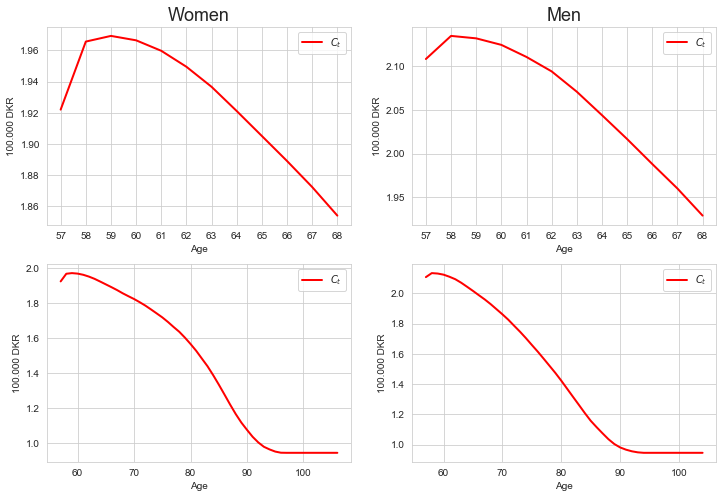

In [8]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.lifecycle(Single,axs[0,0],MA=[0],vars=['c'])
figs.lifecycle(Single,axs[0,1],MA=[1],vars=['c'])
figs.lifecycle(Single,axs[1,0],MA=[0],vars=['c'],ages=[57,110])
figs.lifecycle(Single,axs[1,1],MA=[1],vars=['c'],ages=[57,110])
axs[0,0].set_title('Women',size=18)
axs[0,1].set_title('Men',size=18)
plt.show()

### Random consumption functions for high skilled woman with ERP

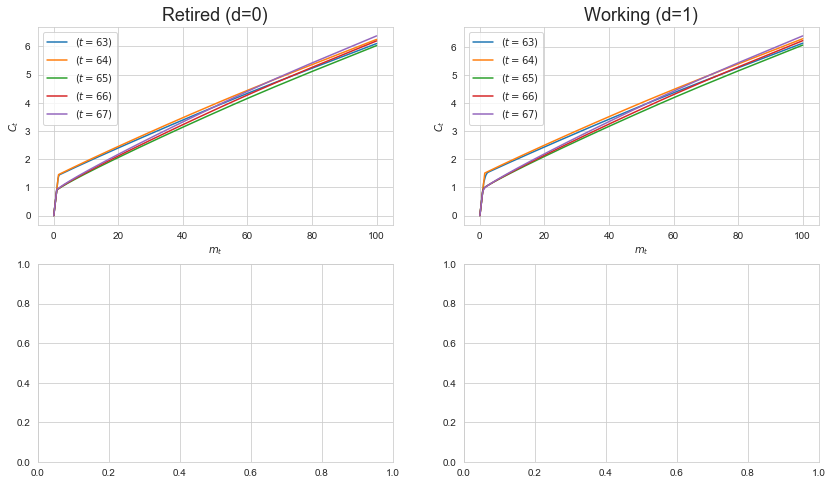

In [28]:
fig, axs = plt.subplots(2,2,figsize=(14,8))
#time = list(range(20,30))
#figs.policy(Single,axs[0,0],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[0],label=['t'])
#time = list(range(40,53))
#figs.policy(Single,axs[1,0],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[0],label=['t'])
figs.policy(Single,axs[0,1],var='c',T=[6,7,8,9,10],MA=[0],ST=[3],RA=[0],D=[1],label=['t'])
figs.policy(Single,axs[0,0],var='c',T=[6,7,8,9,10],MA=[0],ST=[3],RA=[0],D=[0],label=['t'])
#time = list(range(10,20))
#figs.policy(Single,axs[1,1],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[1],label=['t'])
axs[0,0].set_title('Retired (d=0)',size=18)
axs[0,1].set_title('Working (d=1)',size=18)
plt.show()

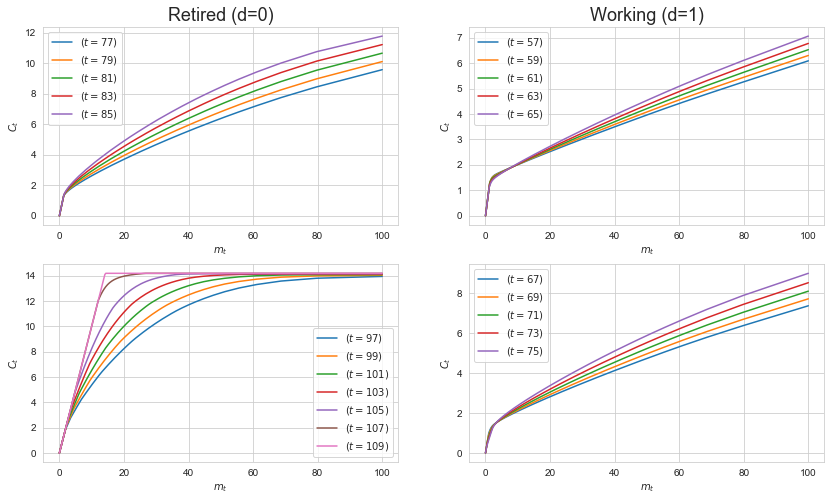

In [5]:
fig, axs = plt.subplots(2,2,figsize=(14,8))
time = list(range(20,30))
figs.policy(test,axs[0,0],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[0],label=['t'])
time = list(range(40,53))
figs.policy(test,axs[1,0],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[0],label=['t'])
time = list(range(10))
figs.policy(test,axs[0,1],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[1],label=['t'])
time = list(range(10,20))
figs.policy(test,axs[1,1],var='c',T=time[::2],MA=[0],ST=[3],RA=[0],D=[1],label=['t'])
axs[0,0].set_title('Retired (d=0)',size=18)
axs[0,1].set_title('Working (d=1)',size=18)
plt.show()

Zoom in on consumption functions for working

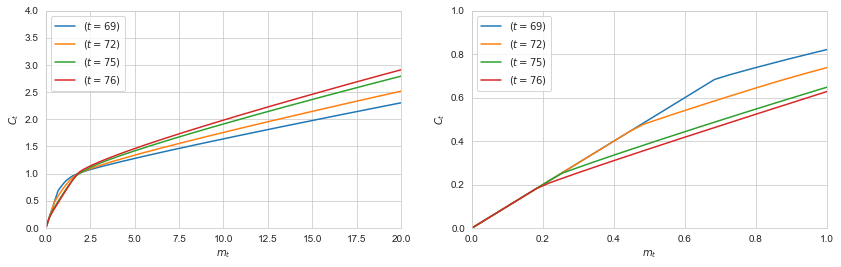

In [42]:
fig, axs = plt.subplots(1,2,figsize=(14,4))
figs.policy(Single,axs[0],var='c',T=[12,15,18,19],MA=[0],ST=[3],RA=[0],D=[1],label=['t'],xlim=[0,20],ylim=[0,4])    
figs.policy(Single,axs[1],var='c',T=[12,15,18,19],MA=[0],ST=[3],RA=[0],D=[1],label=['t'],xlim=[0,1],ylim=[0,1])
plt.show()

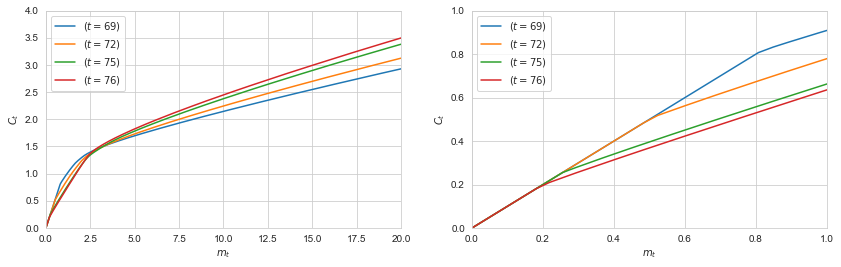

In [6]:
fig, axs = plt.subplots(1,2,figsize=(14,4))
figs.policy(test,axs[0],var='c',T=[12,15,18,19],MA=[0],ST=[3],RA=[0],D=[1],label=['t'],xlim=[0,20],ylim=[0,4])    
figs.policy(test,axs[1],var='c',T=[12,15,18,19],MA=[0],ST=[3],RA=[0],D=[1],label=['t'],xlim=[0,1],ylim=[0,1])
plt.show()

For low level of wealth consumption is larger, when young. However this effect is reversed for higher level of wealth

The reason is that labor income begin to decrease around age 60 (see below). Thus older individuals will have lower income, and therefore consume less for low level of wealth (they escape the constraint faster). However for high level of wealth the savings motive (saving for the future) is more important. Here older individuals have fewer future time periods and discount harder (due to lower survival probabilities), they will therefore consume more (save less).

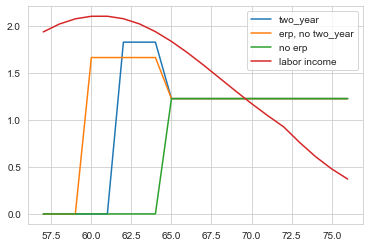

In [21]:
par = test.par
name = ['two_year', 'erp, no two_year', 'no erp']
T = 20
ages = transitions.age(np.arange(T),test.par)
post = np.zeros(T)
for t in range(T):
    pre = transitions.labor_pretax(t,0,3,par)
    post[t] = transitions.labor_posttax(t,pre,0,par,1)
for ra in [0,1,2]:
    plt.plot(ages, par.pension_arr[:T,0,0,ra,0], label=name[ra])
plt.plot(ages,post, label='labor income')
plt.legend()

### Zoom in on consumption functions around the ERP age for d=0 across different retirement status (ra)

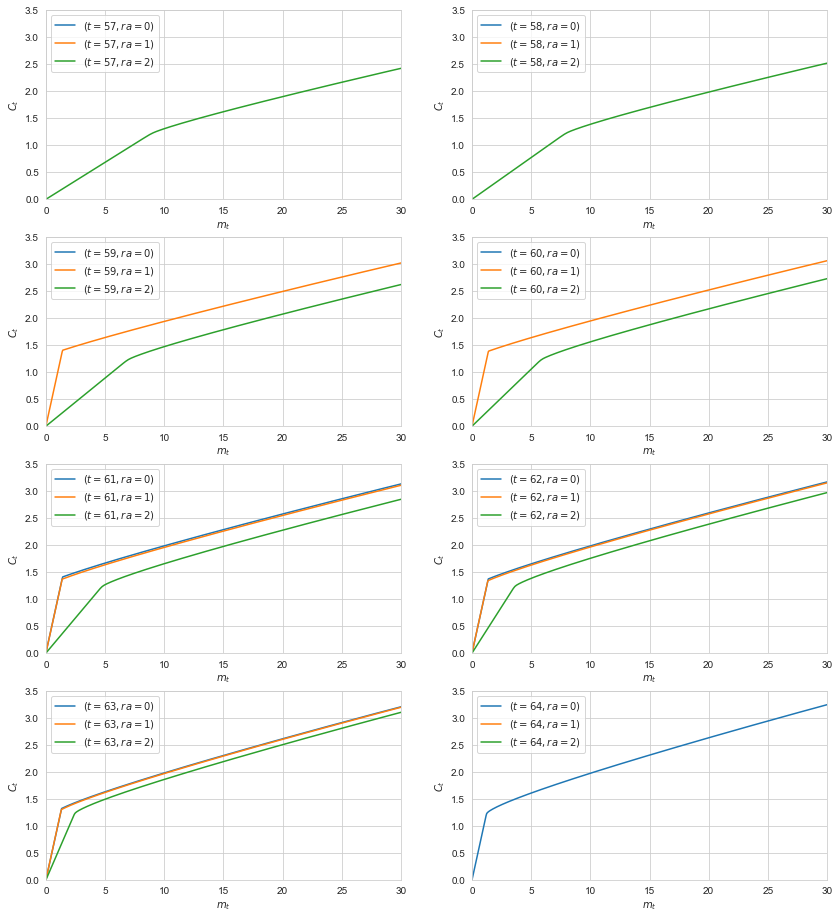

In [22]:
nrow = 4
ncol = 2
fig, axes = plt.subplots(nrow,ncol,figsize=(14,16))
axs = axes.flatten()
for t in range(nrow*ncol):        
    figs.policy(test,axs[t],var='c',T=[t],MA=[0],ST=[3],RA=[0,1,2],D=[0],label=['t','ra'],xlim=[0,30],ylim=[0,3.5])
plt.show()

### Average retirement probabilities

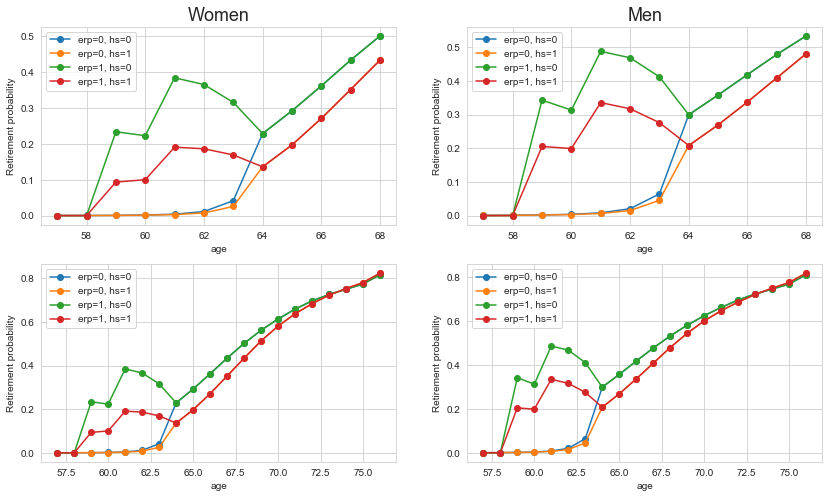

In [12]:
fig, axs = plt.subplots(2,2,figsize=(14,8))
figs.choice_probs(test,axs[0,0],AD=0,MA=0,ST=[0,1,2,3])
figs.choice_probs(test,axs[0,1],AD=0,MA=1,ST=[0,1,2,3])
figs.choice_probs(test,axs[1,0],AD=0,MA=0,ST=[0,1,2,3], ages=[57,77])
figs.choice_probs(test,axs[1,1],AD=0,MA=1,ST=[0,1,2,3], ages=[57,77])
axs[0,0].set_title('Women',size=18)
axs[0,1].set_title('Men',size=18)
plt.show()

# Simulate

### Initialized wealth distribution

In [80]:
np.mean(m0)

14.916392270313324

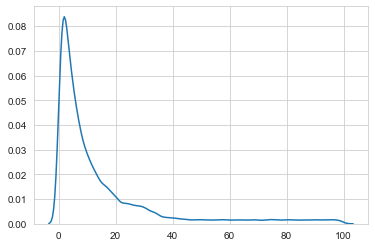

median: 6.943
mean:   14.916
std:    20.383


In [296]:
m0 = Single.sim.m[:,0]
sns.kdeplot(m0,gridsize=200)
plt.show()
print('median:',np.round(np.median(m0),3))
print('mean:  ',np.round(np.mean(m0),3))
print('std:   ',np.round(np.std(m0),3))

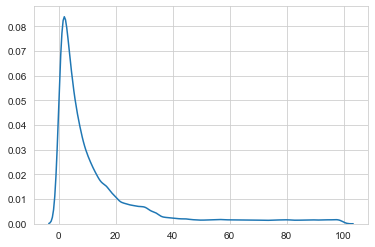

median: 6.962
mean:   14.928
std:    20.401


In [24]:
m0 = test.sim.m[:,0]
sns.kdeplot(m0,gridsize=200)
plt.show()
print('median:',np.round(np.median(m0),3))
print('mean:  ',np.round(np.mean(m0),3))
print('std:   ',np.round(np.std(m0),3))

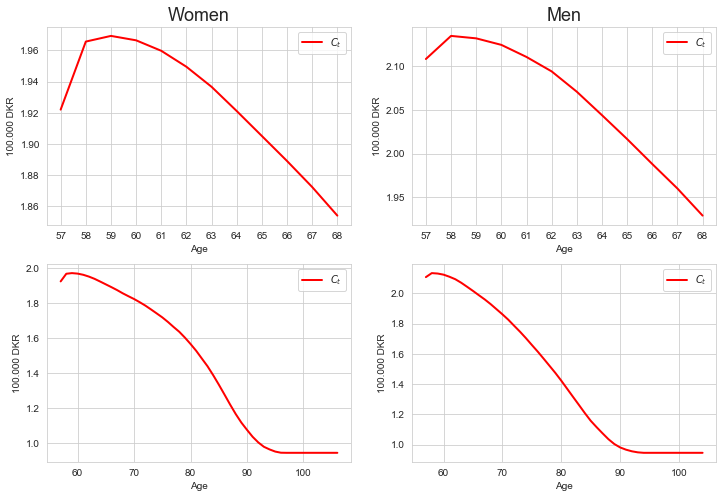

In [297]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.lifecycle(Single,axs[0,0],MA=[0],vars=['c'])
figs.lifecycle(Single,axs[0,1],MA=[1],vars=['c'])
figs.lifecycle(Single,axs[1,0],MA=[0],vars=['c'],ages=[57,110])
figs.lifecycle(Single,axs[1,1],MA=[1],vars=['c'],ages=[57,110])
axs[0,0].set_title('Women',size=18)
axs[0,1].set_title('Men',size=18)
plt.show()

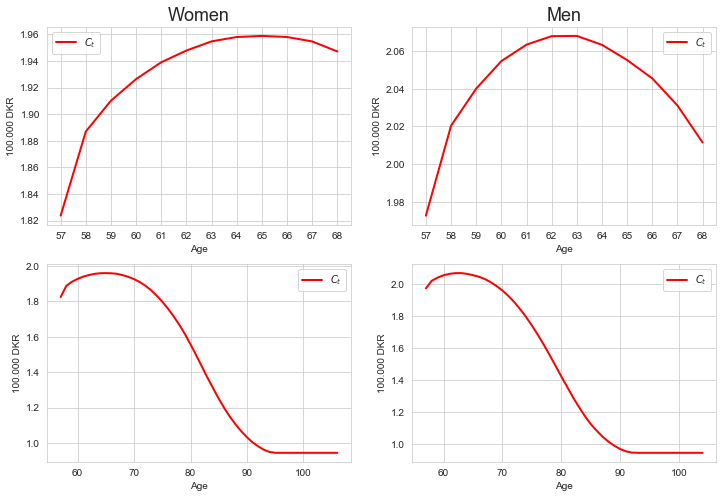

In [75]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.lifecycle(Single,axs[0,0],MA=[0],vars=['c'])
figs.lifecycle(Single,axs[0,1],MA=[1],vars=['c'])
figs.lifecycle(Single,axs[1,0],MA=[0],vars=['c'],ages=[57,110])
figs.lifecycle(Single,axs[1,1],MA=[1],vars=['c'],ages=[57,110])
axs[0,0].set_title('Women',size=18)
axs[0,1].set_title('Men',size=18)
plt.show()

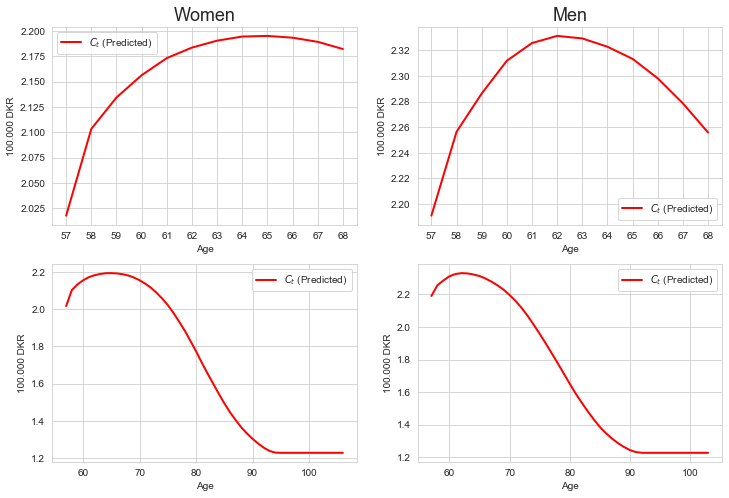

In [43]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.lifecycle(test,axs[0,0],ma=0,vars=['c'],quantiles=False)
figs.lifecycle(test,axs[0,1],ma=1,vars=['c'],quantiles=False)
figs.lifecycle(test,axs[1,0],ma=0,vars=['c'],ages=[57,110],quantiles=False)
figs.lifecycle(test,axs[1,1],ma=1,vars=['c'],ages=[57,110],quantiles=False)
axs[0,0].set_title('Women',size=18)
axs[0,1].set_title('Men',size=18)
plt.show()

In [81]:
m0 = Single.sim.m[:,0]

In [82]:
Single.sim.m[:,0] = m0 + 10

In [83]:
Single.simulate()

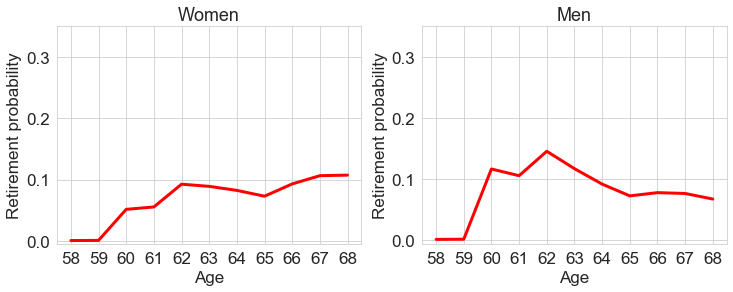

In [84]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.retirement_probs(Single,axs[0],MA=[0])
figs.retirement_probs(Single,axs[1],MA=[1])
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
plt.show()

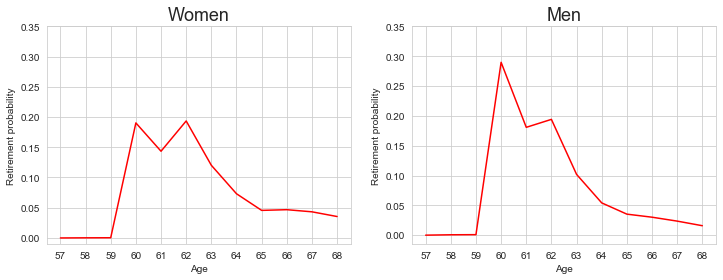

In [44]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.retirement_probs(test,axs[0],ma=0)
figs.retirement_probs(test,axs[1],ma=1)
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
plt.show()

# Euler errors

### Plotting across states

Total: -5.385945720070889


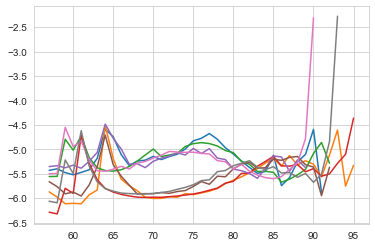

In [298]:
MA = [0,1]
ST = [0,1,2,3]
ages = [Single.par.start_T,Single.par.end_T-1]
for ma in MA:
    for st in ST:
        funs.log_euler(Single,MA=[ma],ST=[st],ages=ages,plot=True)
print('Total:',funs.log_euler(Single,ages=ages)[0])

Total: -5.544589703394773


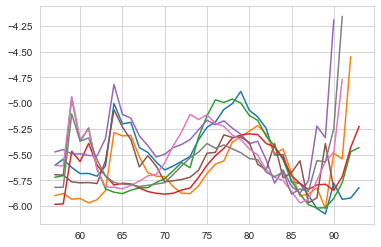

In [31]:
MA = [0,1]
ST = [0,1,2,3]
ages = [Single.par.start_T,Single.par.end_T-1]
for ma in MA:
    for st in ST:
        funs.log_euler(Single,MA=[ma],ST=[st],ages=ages,plot=True)
print('Total:',funs.log_euler(Single,ages=ages)[0])

Total: -5.543345702081455


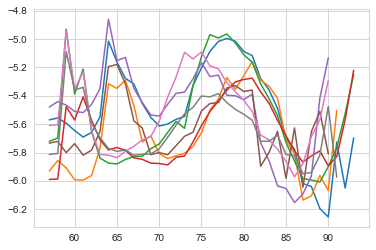

In [4]:
MA = [0,1]
ST = [0,1,2,3]
ages = [test.par.start_T,test.par.end_T-1]
for ma in MA:
    for st in ST:
        funs.log_euler(test,MA=[ma],ST=[st],ages=ages,plot=True)
print('Total:',funs.log_euler(test,ages=ages)[0])

Total: -5.541546313564529


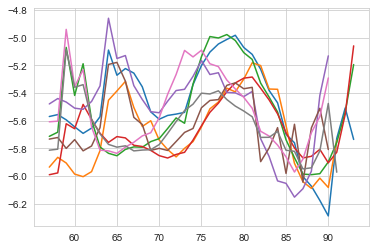

In [47]:
MA = [0,1]
ST = [0,1,2,3]
ages = [test.par.start_T,test.par.end_T-1]
for ma in MA:
    for st in ST:
        funs.log_euler(test,MA=[ma],ST=[st],ages=ages,plot=True)
print('Total:',funs.log_euler(test,ages=ages)[0])

### Can euler errors be improved?

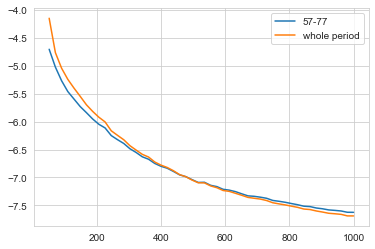

In [8]:
Na = test.par.Na
funs.resolve(test,Na=np.linspace(50,1000))
test.par.Na = Na
test.solve(recompute=True) # reset

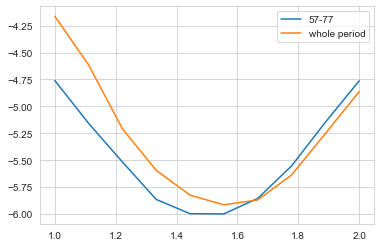

In [9]:
a_phi = test.par.a_phi
funs.resolve(test,a_phi = np.linspace(1.0,2.0,num=10))
test.par.a_phi = a_phi
test.solve(recompute=True) # reset

# Time the model and simulation

In [36]:
Single.par.simT=12

In [37]:
def solve():
    Single.solve() 
    
def simulate():
    Single.simulate()
    
funcs = [solve,simulate]
argu = dict([(funcs[0], []),
             (funcs[1], [])])
names = dict([(funcs[0], 'solve: #a=' + str(Single.par.Na)),
              (funcs[1], 'simulate: T=12, N=' + str(Single.par.simN))])

In [ ]:
funs.my_timer(funcs,argu,names,unit='s',ndigits=2,Ntimes=50)

In [12]:
funs.my_timer(funcs,argu,names,unit='s',ndigits=2,Ntimes=50)

time unit is: s
+--------------------------+------+--------+------+------+-------+
|           func           |  lq  | median | mean |  uq  | neval |
+--------------------------+------+--------+------+------+-------+
|      solve: #a=200       | 0.14 |  0.15  | 0.15 | 0.16 |  50.0 |
| simulate: T=20, N=100000 | 0.8  |  0.84  | 0.85 | 0.88 |  50.0 |
+--------------------------+------+--------+------+------+-------+
